In [44]:
pip install langgraph

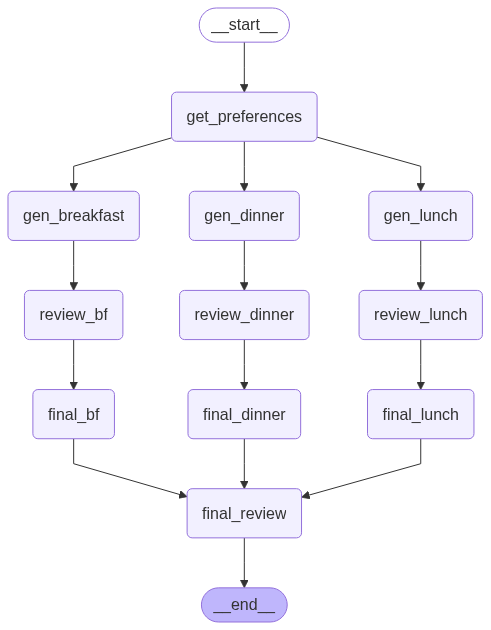

In [45]:
#from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langgraph.types import interrupt, Command
from typing import Annotated
from operator import add
from langgraph.checkpoint.memory import MemorySaver
import uuid


class workflowState(TypedDict):
    preferences: list[str]
    breakfast: list[str]
    lunch: list[str]
    dinner: list[str]

# -------- Init LLM --------
# llm = init_chat_model("google_genai:gemini-2.0-flash")


def get_preferences(state: workflowState):
    state["preferences"] = "vegetarian"
    return {"preferences": state["preferences"]}

def gen_breakfast(state: workflowState):
    # result = llm.invoke(f"Generate {state['preferences']} breakfast options")
    # user_input1 = input("Enter breakfast list: ")
    state["breakfast"] = state.get("breakfast") or ["idly", "upma"]
    # print(f"{[breakfast]}-------------")
    #state["breakfast"] = [item.strip() for item in user_input1.split(",")]
    return {"breakfast": state["breakfast"]}

def gen_lunch(state: workflowState):
    # user_input2 = input("Enter lunch list: ")
    state["lunch"] = state.get("lunch") or ["rice", "dal", "vegetable curry"]
    # state["lunch"] = [item.strip() for item in user_input2.split(",")]
    return {"lunch": state["lunch"]}

def gen_dinner(state: workflowState):
    # user_input3 = input("Enter dinner list: ")
    state["dinner"] = state.get("dinner") or ["chapati", "paneer"]
    # state["dinner"] = [item.strip() for item in user_input3.split(",")]
    return {"dinner": state["dinner"]}

def review_meal(state: workflowState, meal_key: str, next_node: str):
    print(f"\nReview {meal_key}: {state[meal_key]}")
    decision = interrupt(f"Approve {meal_key}? Say 'yes' to approve, or anything else to regenerate.")
    # if decision == "yes":
    #   return Command(goto=next_node)
    # else:
    #     user_input = input(f"Enter {meal_key} list: ")
    #     return Command(goto=f"gen_{meal_key}")
    return state

def review_bf(state: workflowState):
    print(f"\nReview breakfast: {state['breakfast']}")
    decision = interrupt(f"Approve breakfast? Say 'yes' to approve, or anything else to regenerate.")
    return {"breakfast": state["breakfast"]}

def review_lunch(state: workflowState):
    print(f"\nReview lunch: {state['lunch']}")
    decision = interrupt(f"Approve lunch? Say 'yes' to approve, or anything else to regenerate.")
    return {"lunch": state["lunch"]}

def review_dinner(state: workflowState):
    print(f"\nReview dinner: {state['dinner']}")
    decision = interrupt(f"Approve dinner? Say 'yes' to approve, or anything else to regenerate.")
    return {"dinner": state["dinner"]}

def final_bf(state: workflowState):
    return {"breakfast": state["breakfast"]}

def final_lunch(state: workflowState):
    return {"lunch": state["lunch"]}

def final_dinner(state: workflowState):
    return {"dinner": state["dinner"]}

def final_review(state: workflowState):
    print("\nFinal meal plan:")
    print("Breakfast:", state["breakfast"])
    print("Lunch:", state["lunch"])
    print("Dinner:", state["dinner"])
    return state

graph = StateGraph(workflowState)
memory = MemorySaver()


graph.add_node("get_preferences", get_preferences)
graph.add_node("gen_breakfast", gen_breakfast)
graph.add_node("review_bf", review_bf)
graph.add_node("final_bf", final_bf)

graph.add_node("gen_lunch", gen_lunch)
graph.add_node("review_lunch", review_lunch)
graph.add_node("final_lunch", final_lunch)

graph.add_node("gen_dinner", gen_dinner)
graph.add_node("review_dinner", review_dinner)
graph.add_node("final_dinner", final_dinner)


graph.add_node("final_review", final_review)

# --------------------------------------
graph.add_edge(START, "get_preferences")
graph.add_edge("get_preferences", "gen_breakfast")
graph.add_edge("get_preferences", "gen_lunch")
graph.add_edge("get_preferences", "gen_dinner")

graph.add_edge("gen_breakfast", "review_bf")
graph.add_edge("review_bf", "final_bf")
graph.add_edge("final_bf", "final_review")

graph.add_edge("gen_lunch", "review_lunch")
graph.add_edge("review_lunch", "final_lunch")
graph.add_edge("final_lunch", "final_review")

graph.add_edge("gen_dinner", "review_dinner")
graph.add_edge("review_dinner", "final_dinner")
graph.add_edge("final_dinner", "final_review")

# End
graph.add_edge("final_review", END)

# -------- Compile--------
workflow = graph.compile(checkpointer=memory)

#------------------------------------------------------
from IPython.display import Image, display

try:
  display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    print(Exception)
    #This requires some extra dependencies and is optional
    pass

#---------------------------------------------------------------
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
# result = workflow.invoke({}, config=config, stream_mode="updates")
# result



In [46]:

def maninloop():
  for chunk in workflow.stream({}, config=config, stream_mode="updates"):
      if "__interrupt__" in chunk:
          # node_name, interrupt_data = chunk["__interrupt__"]
          while True:
            print("\n HUMAN REVIEW REQUIRED:")
            interrupt_obj = chunk["__interrupt__"][0]
            print("Prompt:", interrupt_obj.value)

            decision = input("Approve or Regenerate? (yes to approve / no to regenerate): ").strip().lower()

            if decision == "yes":
              # result = workflow.stream(Command(resume=decision), config=config, stream_mode="updates")
              # print(result)

              prompt = interrupt_obj.value
              if "breakfast" in prompt:
                  result = workflow.invoke(Command(goto="review_bf"), config=config, stream_mode="updates")
                  break
              elif "lunch" in prompt:
                  result = workflow.invoke(Command(goto="review_lunch"), config=config, stream_mode="updates")
                  break
              elif "dinner" in prompt:
                  result = workflow.invoke(Command(goto="review_dinner"), config=config, stream_mode="updates")
                  break
              else:
                  raise ValueError("Could not determine the node")
              print(result)

            else:
              prompt = interrupt_obj.value
              if "breakfast" in prompt:
                  user_input = input("Enter breakfast list: ")
                  #breakfast1 = [item.strip() for item in user_input.split(",")]
                  result = workflow.invoke(Command(goto="gen_breakfast", update={"breakfast": user_input}), config=config, stream_mode="updates")
              elif "lunch" in prompt:
                  user_input = input("Enter lunch list: ")
                  #state["lunch"] = [item.strip() for item in user_input.split(",")]
                  result = workflow.invoke(Command(goto="gen_lunch", update={"lunch": user_input}), config=config, stream_mode="updates")
              elif "dinner" in prompt:
                  user_input = input("Enter dinner list: ")
                  #state["dinner"] = [item.strip() for item in user_input.split(",")]
                  result = workflow.invoke(Command(goto="gen_dinner", update={"dinner": user_input}), config=config, stream_mode="updates")
              else:
                  raise ValueError("Could not determine which meal to regenerate.")
              print(result)

maninloop()
print(result)


Review breakfast: ['idly', 'upma']

Review dinner: ['chapati', 'paneer']

Review lunch: ['rice', 'dal', 'vegetable curry']

 HUMAN REVIEW REQUIRED:
Prompt: Approve breakfast? Say 'yes' to approve, or anything else to regenerate.
Approve or Regenerate? (yes to approve / no to regenerate): no
Enter breakfast list: [upma]

Review breakfast: [upma]

Review lunch: ['rice', 'dal', 'vegetable curry']

Review dinner: ['chapati', 'paneer']
[{'gen_breakfast': {'breakfast': '[upma]'}}, {'__interrupt__': (Interrupt(value="Approve breakfast? Say 'yes' to approve, or anything else to regenerate.", id='3a7d7f54cecb134f283f7c514aa0414f'),)}, {'__interrupt__': (Interrupt(value="Approve lunch? Say 'yes' to approve, or anything else to regenerate.", id='dfd44072dca5b7f376a20894a6f4a3ae'),)}, {'__interrupt__': (Interrupt(value="Approve dinner? Say 'yes' to approve, or anything else to regenerate.", id='db96e6ebfdf1dabd0aab9dac9217f835'),)}]

 HUMAN REVIEW REQUIRED:
Prompt: Approve breakfast? Say 'yes' to